# BiLSTM

First we import the necessary libraries.

In [1]:
# Import libraries
import numpy as np
import time
import matplotlib
import matplotlib.image as mpimg
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
import spacy
nltk.download('wordnet')
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, SpatialDropout1D, Conv1D, MaxPooling1D, GRU, BatchNormalization
from tensorflow.keras.layers import Input, Bidirectional, GlobalAveragePooling1D, concatenate, LeakyReLU, GlobalMaxPooling1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


We mount the drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We also import the data.

In [3]:
# Train data 
traindata_all = pd.read_csv('/content/drive/MyDrive/TFM/multimodal_train.tsv',sep='\t')
# Validation data 
validata_all = pd.read_csv('/content/drive/MyDrive/TFM/multimodal_validate.tsv',sep='\t')
# Test data 
testdata_all = pd.read_csv('/content/drive/MyDrive/TFM/multimodal_test_public.tsv',sep='\t')

We select a subset of the dataframe with no missing values in the 'clean_title' column.

In [4]:
# Train data with no missing values
train_data = traindata_all[traindata_all['clean_title'].notnull().to_numpy()]
# Validation data with no missing values
valid_data = validata_all[validata_all['clean_title'].notnull().to_numpy()]
# Test data with no missing values
test_data = testdata_all[testdata_all['clean_title'].notnull().to_numpy()]

And we separate the datasets into the texts and the labels.

In [5]:
## Train data
train_news = list(train_data['clean_title'])
train_labels = list(train_data['6_way_label'])
## Valid data
valid_news = list(valid_data['clean_title'])
valid_labels = list(valid_data['6_way_label'])
## Test data
test_news = list(test_data['clean_title'])
test_labels = list(test_data['6_way_label'])

## Preprocessing

We define a function to preprocess the data. We remove punctuations and numbers and also multiple spaces.

In [6]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
# Remove puntuations and numbers and multiple spaces

train_news_clean_1 = []
valid_news_clean_1 = []
test_news_clean_1 = []
# Train
for new in train_news:
    train_news_clean_1.append(preprocess_text(new))
# Validation
for new in valid_news:
    valid_news_clean_1.append(preprocess_text(new))
# Test
for new in test_news:
    test_news_clean_1.append(preprocess_text(new))

Now we create a function to remove stop words and perform lemmatization.

In [8]:
# Funtion to remove stop-words and perform lemmatization

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

# Function to remove stopwords
def remove_stopwords_lem(text):
    text = word_tokenize(text)
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    # Lematization
    lemmatized_text = []
    for word in text:
        word1 = lemmatizer.lemmatize(word, pos = "n")
        word2 = lemmatizer.lemmatize(word1, pos = "v")
        word3 = lemmatizer.lemmatize(word2, pos = ("a"))
        lemmatized_text.append(word3)
        
    text_done = ' '.join(lemmatized_text)
    return text_done

We remove stop words and perform lemmatization.

In [9]:
# Stop-words removal and lemmatization
train_stwrd_lem = []
valid_stwrd_lem = []
test_stwrd_lem = []

# Train
for new in train_news_clean_1:
    train_stwrd_lem.append(remove_stopwords_lem(new))
# Validation
for new in valid_news_clean_1:
    valid_stwrd_lem.append(remove_stopwords_lem(new))
# Test
for new in test_news_clean_1:
    test_stwrd_lem.append(remove_stopwords_lem(new))

We train a tokenizer using all the documents and we used the learned vocabulary in order to transform texts into sequences of ID's.

In [10]:
news_all = train_stwrd_lem + valid_stwrd_lem + test_stwrd_lem

tokenizer = Tokenizer(num_words = 128022)
tokenizer.fit_on_texts(news_all)

# Tokenize news

# Train
train_tokenized = tokenizer.texts_to_sequences(train_stwrd_lem)
# Validation
valid_tokenized = tokenizer.texts_to_sequences(valid_stwrd_lem)
# Test
test_tokenized = tokenizer.texts_to_sequences(test_stwrd_lem)

Obtain the vocabulary length.

In [11]:
print("Vocabulary length: ", len(tokenizer.word_index))

Vocabulary length:  117129


Now we pad the sequences of numbers generated by the tokenizer. But firstly we check how many sequences are shorter than a given length. We start by defining a function that counts the length of each sequence.

In [12]:
# Function to count the lenght of each sequence
def length_squences(data):
    lengths = []
    for i in range(len(data)):
        lengths.append(len(data[i]))
    return lengths

Now we count the lenghts of all the sequences in the training, validation and test set and we check what % of sequences in the train, validation and test sets are smaller than a given length when they are tokenized.

In [13]:
length = [10, 15, 20, 25]

# Train set
lengths_train = np.array(length_squences(train_tokenized))
perc_length_train = []
for lgth in length:
   perc_length_train.append( sum(lengths_train < lgth)/len(lengths_train)*100)
print("Pertentages (train):", perc_length_train)

# Validation set 
lengths_valid = np.array(length_squences(valid_tokenized))
perc_length_valid = []
for lgth in length:
   perc_length_valid.append( sum(lengths_valid < lgth)/len(lengths_valid)*100)
print("Pertentages (validation):", perc_length_valid)

# Test set
lengths_test = np.array(length_squences(test_tokenized))
perc_length_test = []
for lgth in length:
   perc_length_test.append( sum(lengths_test < lgth)/len(lengths_test)*100)
print("Pertentages (test):", perc_length_test)

Pertentages (train): [91.42251773049645, 98.45230496453901, 99.49361702127659, 99.81382978723404]
Pertentages (validation): [91.54898722658487, 98.43449833170436, 99.49614101311045, 99.80957837619225]
Pertentages (test): [91.31812741280197, 98.44063453530909, 99.50268885180128, 99.8179335457442]


We plot the results.

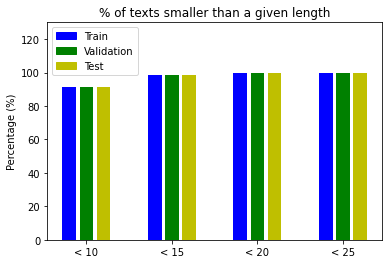

In [14]:
import matplotlib.pyplot as plt
# create dataset
bars = [91.42, 91.55, 91.32, 98.45, 98.43, 98.44, 99.49, 99.50, 99.50, 99.81, 99.81, 99.82]
labels = ['< 10', '< 15', '< 20', '< 25']

x_pos_bars = [1, 2, 3, 6, 7, 8, 11, 12, 13, 16, 17, 18]
x_pos_labels = [2, 7, 12, 17]

# Colors and mapping to values
colors = ['b', 'g', 'y']
colors_values = {'Train':'b', 'Validation':'g', 'Test': 'y'}    

labels2 = list(colors_values.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_values[label]) for label in labels2]
# Make the plot
plt.bar(x_pos_bars, bars,color = colors, label = colors_values)

# Create names on the x-axis
plt.xticks(x_pos_labels, labels)
plt.legend(handles, labels2)
plt.ylim([0, 130])
#plt.xlabel('Metrics')
plt.ylabel('Percentage (%)')
plt.title('% of texts smaller than a given length')
plt.show()

As we can see almost all news are smaller than **15** in length when tokenized so choosing this lenght to truncate the tokenized news will not eliminate any information from the news in almost any case.

In [15]:
# Pad the tokenized news

# Train
train_tokenized_pad = pad_sequences(train_tokenized, maxlen = 15, truncating = 'post', padding = 'post')
# Validation
valid_tokenized_pad = pad_sequences(valid_tokenized, maxlen = 15, truncating = 'post', padding = 'post')
# Test
test_tokenized_pad = pad_sequences(test_tokenized, maxlen = 15, truncating = 'post', padding = 'post')

In order to use the data with torch we have to transform the arrays into dataloader objects but first they need to be transformed into tensors.

In [16]:
# Transform data arrays into tensors

# Train
train_tensor = torch.Tensor(train_tokenized_pad).int()
# Validation
valid_tensor = torch.Tensor(valid_tokenized_pad).int()
# Test
test_tensor =  torch.Tensor(test_tokenized_pad).int()

# Tranform tensors into data loader objects

# Train
train_set = TensorDataset(train_tensor, torch.Tensor(np.array(train_labels)))
trainloader = DataLoader(train_set, batch_size=60)
# Validation
valid_set = TensorDataset(valid_tensor, torch.Tensor(np.array(valid_labels)))
validloader = DataLoader(valid_set, batch_size=60)
# Test
test_set = TensorDataset(test_tensor, torch.Tensor(np.array(test_labels)))
testloader =  DataLoader(test_set, batch_size=60)

### Word embeddings

We will try different word embeddings an select the one which performs better. We start by creating two functions: one which will be used to load the word embeddings and the other which will create the embedding matrix that we will feed to the embedding layer of the models.

In [ ]:
# Function to load the word embeddings

def load_embedd(filename):
    words = []
    vectors = []
    file = open(filename,'r', encoding="utf8")
    for line in file.readlines():
       row = line.split(' ')
       vocab = row[0]
       embd = row[1:len(row)]
       embd[-1] = embd[-1].rstrip()
       embd = list(map(float,embd)) # convert string to float
       words.append(vocab)
       vectors.append(embd)
    file.close()
    return words,vectors

Function to create the embedding matrix.

In [ ]:
# Function to create the embedding matrix

def embed_matx(word_index, vocab, embeddings, length_vocab, length_embedding):
    embedding_matrix = np.zeros((length_vocab +1, length_embedding))
    for word, i in word_index.items():
        if word in vocab:
            idx = vocab.index(word)
            vector =  embeddings[idx]
            embedding_matrix[i] = vector
        if i == length_vocab:
            break
    return embedding_matrix

#### Glove (300 d)

We use GloVe embeddings of dimension 300.

In [ ]:
vocab_gv_300, vectors_gv_300 = load_embedd(filename = "/content/drive/MyDrive/TFM/glove.6B.300d.txt")

Now we create the embbeding matrix

In [ ]:
word_index = tokenizer.word_index
# Embedding matrix
embedding_matrix_gv_300 = embed_matx(word_index = word_index, vocab = vocab_gv_300, embeddings = vectors_gv_300, 
                             length_vocab = 117129, length_embedding = 300)

## Models

First we define the BiLSTM that we will use.

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, nlabels, train_parameters = True, random_embeddings = True): 
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings = 117130, embedding_dim = 300)
        
        if random_embeddings == True:
            self.embedding.weight = nn.Parameter(torch.rand(117130, 300), requires_grad = train_parameters)
        else:
            self.embedding.weight = nn.Parameter(torch.from_numpy(embedding_matrix_gv_300), requires_grad = train_parameters)

        #  convolutional layer 1.1
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels = 240,kernel_size = (3,140), 
                               stride=1, padding=0)
        
        # BiLSTM layer 
        
        self.lstm1 = nn.LSTM(input_size = 300, hidden_size = 70,num_layers = 1, batch_first = True,  bidirectional = True)
   
        # Linear layers
        self.linear1 = nn.Linear(240,64)
  
        self.linear2 = nn.Linear(64,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        # BiLSTM ayer
        x_1, _ = self.lstm1(x.float())
        # Convolutional layer2
        x_1 = self.conv1_1(x_1.unsqueeze(1).float()).squeeze(3) 
        x_1 = self.relu(x_1)
        # Max pool
        x_1 = F.max_pool1d(x_1, x_1.size(2)).squeeze(2)
        # Linear layers
        x = self.linear1(x_1)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.logsoftmax(x) 
        return x

In [ ]:
class BiLSTM_extended(BiLSTM):
    
    def __init__(self,nlabels, train_parameters, random_embeddings, epochs=100, lr=0.001):
        
        super().__init__(nlabels, train_parameters, random_embeddings)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader, validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):

            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            i = 0
            
            length = 0
            
            accuracies = []
            
            for news, labels in trainloader:  

                 # Move input and label tensors to the default device
                news, labels = news.to(self.device), labels.to(self.device)           
        
                self.optim.zero_grad()  # Reset gradients
            
                out = self.forward(news.int())

                loss = self.criterion(out,labels.long())
                
                loss.backward()

                running_loss += loss.item()

                self.optim.step()
                
                top_p, top_class = out.topk(1, dim=1)
                
                equals = (top_class == labels.view(news.shape[0], 1))
                
                length += news.shape[0]
                
                accuracies.append(sum(equals)) 
                
                accuracy = sum(accuracies)/length
                
                i += 1
                
                if i%1000 == 0:
                    print(" Train accuracy: ", accuracy)
       
                
            self.loss_during_training.append(running_loss/len(trainloader))

            # Validation Loss
            
            with torch.no_grad():            
                
                running_loss = 0.
                
                i = 0
                
                length = 0
                
                accuracies = []
                
                for news,labels in validloader:

                    # Move input and label tensors to the default device
                    news, labels = news.to(self.device), labels.to(self.device)
                    
                    out = self.forward(news.int())

                    loss = self.criterion(out,labels.long())

                    running_loss += loss.item()   
                    
                    top_p, top_class = out.topk(1, dim=1)
                
                    equals = (top_class == labels.view(news.shape[0], 1))
                
                    length += news.shape[0]
                
                    accuracies.append(sum(equals)) 
                
                    accuracy = sum(accuracies)/length
                    

                print(" Validation accuracy: ", accuracy)                    
                      
                self.valid_loss_during_training.append(running_loss/len(validloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]), "Validation loss after %d epochs: %f" %(e,self.valid_loss_during_training[-1]),
                      "Time per epoch: %f seconds"%(time.time() - start_time))

We train the CNN in **4** different scenarios:

  - **Random embeddings** + **Training embeddings**
  - **GloVe embeddings** + **Training embeddings**
  - **Random embeddings** + **Not training embeddings**
  - **GloVe embeddings** + **Not training embeddings**
  
We train the model for several epochs. This is done in order to select the optimal number of epochs, which occurs when the validation loss stops decreasing and starts increasing (Early Stopping).

### Random embeddings  + Training embeddings

In [ ]:
# Initialize model
BiLSTM_train_random = BiLSTM_extended(nlabels = 6, epochs=5, lr=0.003, train_parameters = True, random_embeddings = True)
# Train model
BiLSTM_train_random.trainloop(trainloader, validloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Train accuracy:  tensor([0.5999])
 Train accuracy:  tensor([0.6277])
 Train accuracy:  tensor([0.6447])
 Train accuracy:  tensor([0.6559])
 Train accuracy:  tensor([0.6636])
 Train accuracy:  tensor([0.6699])
 Train accuracy:  tensor([0.6748])
 Train accuracy:  tensor([0.6789])
 Train accuracy:  tensor([0.6824])
 Validation accuracy:  tensor([0.7135])
Training loss after 0 epochs: 0.888133 Validation loss after 0 epochs: 0.810962 Time per epoch: 5854.538054 seconds
 Train accuracy:  tensor([0.7253])
 Train accuracy:  tensor([0.7286])
 Train accuracy:  tensor([0.7309])
 Train accuracy:  tensor([0.7326])
 Train accuracy:  tensor([0.7343])
 Train accuracy:  tensor([0.7358])
 Train accuracy:  tensor([0.7368])
 Train accuracy:  tensor([0.7376])
 Train accuracy:  tensor([0.7381])
 Validation accuracy:  tensor([0.7124])
Training loss after 1 epochs: 0.742461 Validation loss after 1 epochs: 0.824408 Time per epoch: 7212.685507 seconds
 Train accuracy:  tensor([0.7549])
 Train accuracy:  tenso

### GloVe embeddings  + Training embeddings

In [ ]:
# Initialize model
BiLSTM_train_not_random = BiLSTM_extended(nlabels = 6, epochs=4, lr=0.003, train_parameters = True, random_embeddings = False)
# Train model
BiLSTM_train_not_random.trainloop(trainloader, validloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Train accuracy:  tensor([0.6648])
 Train accuracy:  tensor([0.6859])
 Train accuracy:  tensor([0.6958])
 Train accuracy:  tensor([0.7027])
 Train accuracy:  tensor([0.7080])
 Train accuracy:  tensor([0.7122])
 Train accuracy:  tensor([0.7157])
 Train accuracy:  tensor([0.7184])
 Train accuracy:  tensor([0.7209])
 Validation accuracy:  tensor([0.7421])
Training loss after 0 epochs: 0.785417 Validation loss after 0 epochs: 0.731576 Time per epoch: 5656.640536 seconds
 Train accuracy:  tensor([0.7695])
 Train accuracy:  tensor([0.7776])
 Train accuracy:  tensor([0.7805])
 Train accuracy:  tensor([0.7824])
 Train accuracy:  tensor([0.7839])
 Train accuracy:  tensor([0.7849])
 Train accuracy:  tensor([0.7855])
 Train accuracy:  tensor([0.7860])
 Train accuracy:  tensor([0.7867])
 Validation accuracy:  tensor([0.7400])
Training loss after 1 epochs: 0.610808 Validation loss after 1 epochs: 0.762398 Time per epoch: 5298.509585 seconds
 Train accuracy:  tensor([0.8056])
 Train accuracy:  tenso

### Random embeddings  + Not training embeddings

In [ ]:
# Initialize model
BiLSTM_not_train_random = BiLSTM_extended(nlabels = 6, epochs=9, lr=0.003, train_parameters = False, random_embeddings = True)
# Train model
BiLSTM_not_train_random.trainloop(trainloader, validloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Train accuracy:  tensor([0.5545])
 Train accuracy:  tensor([0.5616])
 Train accuracy:  tensor([0.5648])
 Train accuracy:  tensor([0.5681])
 Train accuracy:  tensor([0.5727])
 Train accuracy:  tensor([0.5762])
 Train accuracy:  tensor([0.5804])
 Train accuracy:  tensor([0.5850])
 Train accuracy:  tensor([0.5893])
 Validation accuracy:  tensor([0.6140])
Training loss after 0 epochs: 1.115259 Validation loss after 0 epochs: 1.082880 Time per epoch: 631.668183 seconds
 Train accuracy:  tensor([0.6276])
 Train accuracy:  tensor([0.6283])
 Train accuracy:  tensor([0.6289])
 Train accuracy:  tensor([0.6301])
 Train accuracy:  tensor([0.6307])
 Train accuracy:  tensor([0.6316])
 Train accuracy:  tensor([0.6325])
 Train accuracy:  tensor([0.6331])
 Train accuracy:  tensor([0.6339])
 Validation accuracy:  tensor([0.6319])
Training loss after 1 epochs: 1.018149 Validation loss after 1 epochs: 1.029225 Time per epoch: 686.650449 seconds
 Train accuracy:  tensor([0.6419])
 Train accuracy:  tensor(

### GloVe embeddings  + Not training embeddings

In [ ]:
# Initialize model
BiLSTM_not_train_not_random = BiLSTM_extended(nlabels = 6, epochs=9, lr=0.003, train_parameters = False, random_embeddings = False)
# Train model
BiLSTM_not_train_not_random.trainloop(trainloader, validloader)

 Train accuracy:  tensor([0.6477])
 Train accuracy:  tensor([0.6681])
 Train accuracy:  tensor([0.6778])
 Train accuracy:  tensor([0.6845])
 Train accuracy:  tensor([0.6895])
 Train accuracy:  tensor([0.6939])
 Train accuracy:  tensor([0.6970])
 Train accuracy:  tensor([0.6998])
 Train accuracy:  tensor([0.7026])
 Validation accuracy:  tensor([0.7208])
Training loss after 0 epochs: 0.834196 Validation loss after 0 epochs: 0.785574 Time per epoch: 647.588372 seconds
 Train accuracy:  tensor([0.7267])
 Train accuracy:  tensor([0.7287])
 Train accuracy:  tensor([0.7290])
 Train accuracy:  tensor([0.7302])
 Train accuracy:  tensor([0.7311])
 Train accuracy:  tensor([0.7323])
 Train accuracy:  tensor([0.7328])
 Train accuracy:  tensor([0.7336])
 Train accuracy:  tensor([0.7346])
 Validation accuracy:  tensor([0.7241])
Training loss after 1 epochs: 0.747840 Validation loss after 1 epochs: 0.777635 Time per epoch: 642.568994 seconds
 Train accuracy:  tensor([0.7410])
 Train accuracy:  tensor(

## Testing performance

We join the **train** and **validation** datasets and we train the model with this dataset using the optimal number of epochs. Then we evaluate the model with the **test** set. First we need to modify a bit the class used previously.

In [ ]:
class BiLSTM_extended(BiLSTM):
    
    def __init__(self,nlabels, train_parameters, random_embeddings, epochs=100,lr=0.001):
        
        super().__init__(nlabels, train_parameters, random_embeddings)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader):
        
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):

            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            i = 0
            
            length = 0
            
            accuracies = []
            
            for news, labels in trainloader:             
        
                self.optim.zero_grad()  # Reset gradients
            
                out = self.forward(news.int())

                loss = self.criterion(out,labels.long())
                
                loss.backward()

                running_loss += loss.item()

                self.optim.step()
                
                top_p, top_class = out.topk(1, dim=1)
                
                equals = (top_class == labels.view(news.shape[0], 1))
                
                length += news.shape[0]
                
                accuracies.append(sum(equals)) 
                
                accuracy = sum(accuracies)/length
                
                i += 1
                
                if i%1000 == 0:
                    print(" Train accuracy: ", accuracy)
                
            self.loss_during_training.append(running_loss/len(trainloader))
            end_time = time.time()
            print("Time elapsed during epoch:", end_time - start_time)


                
    def eval_performance(self,dataloader):
        predictions = np.empty((1,1))

        with torch.no_grad():

            for news,labels in dataloader:
                
                logprobs = self.forward(news)  
                top_p, top_class = logprobs.topk(1, dim=1)
                
                top_class_array = np.array(top_class)
                predictions = np.concatenate((predictions, top_class_array), axis = 0)
                
        return predictions[1:]

Now we join the train and validation sets.

In [ ]:
# Join train and validation sequences
train_valid_tokenized_pad = np.concatenate((train_tokenized_pad, valid_tokenized_pad), axis = 0)
# Join train and validation labels
train_valid_labels = np.concatenate((np.array(train_labels), np.array(valid_labels)), axis = 0)

# Create tensor objects

# Train + validation
train_valid_tensor = torch.Tensor(train_valid_tokenized_pad).int()
# Test
test_tensor =  torch.Tensor(test_tokenized_pad).int()

# Tranform tensors into data loader objects

# Train + validation
train_valid_set = TensorDataset(train_valid_tensor, torch.Tensor(np.array(train_valid_labels)))
train_valid_loader = DataLoader(train_valid_set, batch_size=60)
# Test
test_set = TensorDataset(test_tensor, torch.Tensor(np.array(test_labels)))
testloader =  DataLoader(test_set, batch_size=60)

### Random embeddings  + Training embeddings

In [ ]:
# Initialize model
BiLSTM_test_train_random = BiLSTM_extended(nlabels = 6, epochs=1, lr=0.003, train_parameters = True, random_embeddings = True)
# Train model
BiLSTM_test_train_random.trainloop(train_valid_loader)
# Get predictions
predictions1 = BiLSTM_test_train_random.eval_performance(testloader)

 Train accuracy:  tensor([0.5969])
 Train accuracy:  tensor([0.6261])
 Train accuracy:  tensor([0.6435])
 Train accuracy:  tensor([0.6549])
 Train accuracy:  tensor([0.6631])
 Train accuracy:  tensor([0.6699])
 Train accuracy:  tensor([0.6749])
 Train accuracy:  tensor([0.6788])
 Train accuracy:  tensor([0.6825])
 Train accuracy:  tensor([0.6855])
Time elapsed during epoch: 6599.531795501709


In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions1))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78     23507
           1       0.58      0.25      0.35      3514
           2       0.73      0.44      0.55     11297
           3       0.86      0.08      0.14      1224
           4       0.73      0.85      0.79     17472
           5       0.80      0.45      0.58      2305

    accuracy                           0.72     59319
   macro avg       0.74      0.49      0.53     59319
weighted avg       0.72      0.72      0.69     59319



In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions1, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.58      0.25      0.35      3514
           2       0.73      0.44      0.55     11297
           3       0.86      0.08      0.14      1224
           4       0.73      0.85      0.79     17472
           5       0.80      0.45      0.58      2305

   micro avg       0.73      0.61      0.66     35812
   macro avg       0.74      0.41      0.48     35812
weighted avg       0.73      0.61      0.63     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions1))

[[20754   236   812     2  1619    84]
 [ 1456   864   162     2   994    36]
 [ 3778   116  4955     8  2352    88]
 [  791    54    73    93   196    17]
 [ 1867   134   583     3 14853    32]
 [  799    74   174     0   212  1046]]


### GloVe embeddings  + Training embeddings

In [ ]:
# Initialize model
BiLSTM_test_train_not_random = BiLSTM_extended(nlabels = 6, epochs=1, lr=0.003, train_parameters = True, random_embeddings = False)
# Train model
BiLSTM_test_train_not_random.trainloop(train_valid_loader)
# Get predictions
predictions_2 = BiLSTM_test_train_not_random.eval_performance(testloader)

 Train accuracy:  tensor([0.6648])
 Train accuracy:  tensor([0.6852])
 Train accuracy:  tensor([0.6958])
 Train accuracy:  tensor([0.7021])
 Train accuracy:  tensor([0.7072])
 Train accuracy:  tensor([0.7120])
 Train accuracy:  tensor([0.7154])
 Train accuracy:  tensor([0.7183])
 Train accuracy:  tensor([0.7210])
 Train accuracy:  tensor([0.7231])
Time elapsed during epoch: 7875.144319057465


In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_2))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80     23507
           1       0.63      0.41      0.50      3514
           2       0.72      0.55      0.63     11297
           3       0.57      0.18      0.28      1224
           4       0.77      0.84      0.80     17472
           5       0.78      0.57      0.66      2305

    accuracy                           0.75     59319
   macro avg       0.70      0.57      0.61     59319
weighted avg       0.74      0.75      0.73     59319



In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_2, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.63      0.41      0.50      3514
           2       0.72      0.55      0.63     11297
           3       0.57      0.18      0.28      1224
           4       0.77      0.84      0.80     17472
           5       0.78      0.57      0.66      2305

   micro avg       0.74      0.67      0.70     35812
   macro avg       0.69      0.51      0.57     35812
weighted avg       0.73      0.67      0.69     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions_2))

[[20321   317  1184    71  1477   137]
 [ 1130  1444   156    37   696    51]
 [ 2814   161  6267    27  1931    97]
 [  661    40    96   224   171    32]
 [ 1552   287   899    24 14645    65]
 [  599    56   155    12   159  1324]]


### Random embeddings  +  Not training embeddings

In [ ]:
# Initialize model
BiLSTM_test_not_train_random = BiLSTM_extended(nlabels = 6, epochs=9, lr=0.003, train_parameters = False, random_embeddings = True)
# Train model
BiLSTM_test_not_train_random.trainloop(train_valid_loader)
# Get predictions
predictions_3 = BiLSTM_test_not_train_random.eval_performance(testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Train accuracy:  tensor([0.5548])
 Train accuracy:  tensor([0.5622])
 Train accuracy:  tensor([0.5654])
 Train accuracy:  tensor([0.5694])
 Train accuracy:  tensor([0.5759])
 Train accuracy:  tensor([0.5813])
 Train accuracy:  tensor([0.5859])
 Train accuracy:  tensor([0.5899])
 Train accuracy:  tensor([0.5932])
 Train accuracy:  tensor([0.5962])
Time elapsed during epoch: 735.7017230987549
 Train accuracy:  tensor([0.6277])
 Train accuracy:  tensor([0.6287])
 Train accuracy:  tensor([0.6286])
 Train accuracy:  tensor([0.6294])
 Train accuracy:  tensor([0.6310])
 Train accuracy:  tensor([0.6320])
 Train accuracy:  tensor([0.6333])
 Train accuracy:  tensor([0.6343])
 Train accuracy:  tensor([0.6353])
 Train accuracy:  tensor([0.6360])
Time elapsed during epoch: 808.9810855388641
 Train accuracy:  tensor([0.6429])
 Train accuracy:  tensor([0.6446])
 Train accuracy:  tensor([0.6449])
 Train accuracy:  tensor([0.6449])
 Train accuracy:  tensor([0.6458])
 Train accuracy:  tensor([0.6465])


In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_3))

              precision    recall  f1-score   support

           0       0.66      0.86      0.75     23507
           1       0.50      0.11      0.17      3514
           2       0.67      0.33      0.44     11297
           3       0.79      0.04      0.08      1224
           4       0.69      0.83      0.75     17472
           5       0.71      0.36      0.48      2305

    accuracy                           0.67     59319
   macro avg       0.67      0.42      0.45     59319
weighted avg       0.67      0.67      0.63     59319



In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_3, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.50      0.11      0.17      3514
           2       0.67      0.33      0.44     11297
           3       0.79      0.04      0.08      1224
           4       0.69      0.83      0.75     17472
           5       0.71      0.36      0.48      2305

   micro avg       0.68      0.54      0.60     35812
   macro avg       0.67      0.33      0.39     35812
weighted avg       0.67      0.54      0.56     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions_3))

[[20332   157   871     1  2035   111]
 [ 1842   371   127     2  1140    32]
 [ 4522    67  3684     6  2874   144]
 [  899    20    46    53   188    18]
 [ 2294    88   599     4 14460    27]
 [ 1020    45   168     1   241   830]]


### GloVe embeddings  +  Not training embeddings

In [ ]:
# Initialize model
BiLSTM_test_not_train_not_random = BiLSTM_extended(nlabels = 6, epochs=3, lr=0.003, train_parameters = False, random_embeddings = False)
# Train model
BiLSTM_test_not_train_not_random.trainloop(train_valid_loader)
# Get predictions
predictions_4 = BiLSTM_test_not_train_not_random.eval_performance(testloader)

 Train accuracy:  tensor([0.6498])
 Train accuracy:  tensor([0.6686])
 Train accuracy:  tensor([0.6775])
 Train accuracy:  tensor([0.6844])
 Train accuracy:  tensor([0.6897])
 Train accuracy:  tensor([0.6942])
 Train accuracy:  tensor([0.6973])
 Train accuracy:  tensor([0.7002])
 Train accuracy:  tensor([0.7026])
 Train accuracy:  tensor([0.7045])
Time elapsed during epoch: 732.8006269931793
 Train accuracy:  tensor([0.7253])
 Train accuracy:  tensor([0.7283])
 Train accuracy:  tensor([0.7296])
 Train accuracy:  tensor([0.7301])
 Train accuracy:  tensor([0.7313])
 Train accuracy:  tensor([0.7323])
 Train accuracy:  tensor([0.7328])
 Train accuracy:  tensor([0.7338])
 Train accuracy:  tensor([0.7347])
 Train accuracy:  tensor([0.7352])
Time elapsed during epoch: 728.9215531349182
 Train accuracy:  tensor([0.7423])
 Train accuracy:  tensor([0.7436])
 Train accuracy:  tensor([0.7442])
 Train accuracy:  tensor([0.7447])
 Train accuracy:  tensor([0.7453])
 Train accuracy:  tensor([0.7459])


In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_4))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79     23507
           1       0.55      0.41      0.47      3514
           2       0.68      0.55      0.61     11297
           3       0.45      0.17      0.24      1224
           4       0.77      0.82      0.79     17472
           5       0.77      0.55      0.64      2305

    accuracy                           0.73     59319
   macro avg       0.66      0.56      0.59     59319
weighted avg       0.72      0.73      0.72     59319



In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_4, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.55      0.41      0.47      3514
           2       0.68      0.55      0.61     11297
           3       0.45      0.17      0.24      1224
           4       0.77      0.82      0.79     17472
           5       0.77      0.55      0.64      2305

   micro avg       0.72      0.65      0.69     35812
   macro avg       0.65      0.50      0.55     35812
weighted avg       0.71      0.65      0.67     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions_4))

[[19894   496  1386    98  1475   158]
 [ 1074  1442   196    44   719    39]
 [ 2928   182  6167    42  1872   106]
 [  691    64    96   205   147    21]
 [ 1681   356  1022    46 14312    55]
 [  656    68   145    18   154  1264]]
